# 고양이, 개 분류 - CNN v3
- Dropout 추가
- Kaggle에서 'Copy API Command'를 사용하여 API Key를 발급받을 것
- Full Data로 수행

* 데이터 다운로드 및 압축 해제, 훈련/테스트 데이터 분리

In [1]:
from google.colab import files
up = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
import json , os
with open('kaggle.json') as f:
    kaggle = json.load(f)
username = kaggle['username']
kaggle_key = kaggle['key']

In [4]:
#Configuration environment
os.environ['KAGGLE_USERNAME'] = username
os.environ['KAGGLE_KEY'] = kaggle_key 

In [5]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

 99% 778M/788M [00:03<00:00, 243MB/s]
100% 788M/788M [00:03<00:00, 209MB/s]


In [6]:
!unzip microsoft-catsvsdogs-dataset.zip > /dev/null

In [7]:
cat_dir = 'PetImages/Cat'
os.unlink(f'{cat_dir}/Thumbs.db' )
cat_list = os.listdir(cat_dir)
len(cat_list)

12500

In [8]:
dog_dir = 'PetImages/Dog'
os.unlink(f'{dog_dir}/Thumbs.db' )
dog_list = os.listdir(dog_dir)
len(dog_list)

12500

In [9]:
train_dir = 'PetImages/train'
test_dir = 'PetImages/test'
train_cats_dir = f'{train_dir}/cats'
train_dogs_dir = f'{train_dir}/dogs'
test_cats_dir = f'{test_dir}/cats'
test_dogs_dir = f'{test_dir}/dogs'

In [10]:
for dir_name in [train_dir, test_dir, train_cats_dir, train_dogs_dir, test_cats_dir, test_dogs_dir]:
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

In [11]:
for file in cat_list:
    if len(file) < 9:
        os.rename(f'{cat_dir}/{file}', f'{train_cats_dir}/{file}')
    else:
        os.rename(f'{cat_dir}/{file}', f'{test_cats_dir}/{file}')

In [14]:
for file in dog_list:
    if len(file) < 9:
        os.rename(f'{dog_dir}/{file}', f'{train_dogs_dir}/{file}')
    else:
        os.rename(f'{dog_dir}/{file}', f'{test_dogs_dir}/{file}')

In [12]:
len(os.listdir(cat_dir)), len(os.listdir(train_cats_dir)), len(os.listdir(test_cats_dir))

(0, 10000, 2500)

In [17]:
os.rmdir(cat_dir) , os.rmdir(dog_dir)

FileNotFoundError: ignored

In [16]:
len(os.listdir(dog_dir)), len(os.listdir(train_dogs_dir)), len(os.listdir(test_dogs_dir))

(0, 10000, 2500)

* 데이터 탐색

In [18]:
import cv2
import matplotlib.pyplot as plt

In [19]:
# 파일 이름
import os
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)
test_cats_fnames = os.listdir(test_cats_dir)
test_dogs_fnames = os.listdir(test_dogs_dir)
len(train_cats_fnames)
len(train_dogs_fnames)
len(test_cats_fnames)
len(test_dogs_fnames)


2500

In [57]:
# 666.jpg 이미지에 에러가 있어, 12000.jpg 파일로 대체
# dogs/11702.jpg 이미지에 에러가 있어, 12000.jpg 파일로 대체 
!cp PetImages/test/cats/12000.jpg PetImages/train/cats/666.jpg
!cp PetImages/test/dogs/12000.jpg PetImages/test/dogs/11702.jpg

In [35]:
import warnings 
warnings.filterwarnings('ignore')

In [50]:
# del model

* 모델 구성

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [58]:
model = Sequential([
    Conv2D(16, kernel_size=(3,3), input_shape=(150, 150, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 74, 74, 16)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 36, 36, 32)       

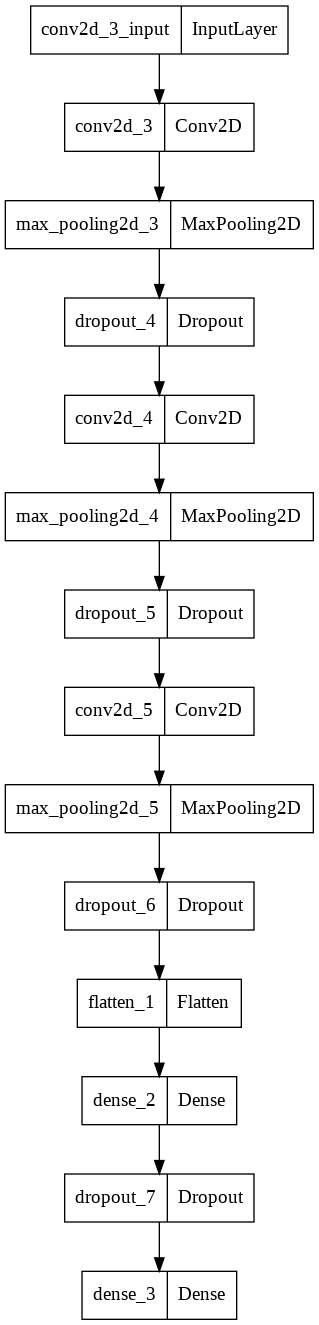

In [38]:
from tensorflow.keras.utils import plot_model
plot_model(model)

* 모델 설정

In [59]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.001, decay=1e-8), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

- 파일에서 이미지 데이터 읽어오는 방법

In [60]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [61]:
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150, 150)
)
test_generator = test_datagen.flow_from_directory(
    test_dir, batch_size=20, class_mode='binary', target_size=(150, 150)
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


* callback 정의

In [62]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = 'best-cat-dog-v3.h5'
checkpoint = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=10)

- 모델 실행

In [63]:
# 어느 파일에서 에러가 발생했는지 알아보는 코드
from PIL import Image
import glob
try:
    for fname in glob.glob(f'{test_dogs_dir}/*.jpg'):
        img = Image.open(fname)
except:
    print(fname)

In [45]:
img = Image.open(f'{test_dogs_dir}/11702.jpg')
plt.imshow(img);

UnidentifiedImageError: ignored

In [64]:
hist = model.fit(
    train_generator, 
    validation_data = test_generator,
    epochs=100, 
    steps_per_epoch=1000,           # 한 번의 epoch에서 훈련에 사용할 batch의 갯수
    validation_steps=250,            # 한 번의 epoch가 끝났을 때, 테스트에 사용되는 batch에 갯수
    verbose=2, 
    callbacks=[checkpoint, early_stop]
)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.51345, saving model to best-cat-dog-v3.h5
1000/1000 - 70s - loss: 0.6050 - accuracy: 0.6663 - val_loss: 0.5134 - val_accuracy: 0.7510 - 70s/epoch - 70ms/step
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.51345
1000/1000 - 69s - loss: 0.5216 - accuracy: 0.7488 - val_loss: 0.5307 - val_accuracy: 0.7428 - 69s/epoch - 69ms/step
Epoch 3/100

Epoch 00003: val_loss improved from 0.51345 to 0.50545, saving model to best-cat-dog-v3.h5
1000/1000 - 69s - loss: 0.4892 - accuracy: 0.7710 - val_loss: 0.5055 - val_accuracy: 0.7546 - 69s/epoch - 69ms/step
Epoch 4/100

Epoch 00004: val_loss improved from 0.50545 to 0.41144, saving model to best-cat-dog-v3.h5
1000/1000 - 69s - loss: 0.4611 - accuracy: 0.7861 - val_loss: 0.4114 - val_accuracy: 0.8082 - 69s/epoch - 69ms/step
Epoch 5/100

Epoch 00005: val_loss improved from 0.41144 to 0.40987, saving model to best-cat-dog-v3.h5
1000/1000 - 69s - loss: 0.4444 - accuracy: 0.7997 - val_loss

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model(model_path)

- 테스트 이미지 분류

In [ ]:
from google.colab import files

up = files.upload()

In [ ]:
for fname in up.keys():
    img = cv2.imread(fname)[:,:,::-1]
    if sum(img.shape[:-1]) > 300: # 150 x 150 보다 큰 이미지
        img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
    else:
        img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_CUBIC)
    classes = best_model.predict(img.reshape(1,150,150,3))
    print(f"{classes[0,0]} {fname} is a {'dog' if classes[0,0] > 0.5 else 'cat'}")

* 학습과정 시각화

In [ ]:
import numpy as np
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.show()